In [1]:
!pip install tf_slim
!pip install tensorflow-object-detection-api
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3WruWNSZHDKBG7psfXkE")
project = rf.workspace("runner-e0dmy").project("acne-ijcab")
version = project.version(1)
dataset = version.download("voc")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 kB 40.4 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844488 sha256=54f70eb1b3d71995d4233fb28569503ef2b23fb46e37c831e74c7be814527c55
  Stored in directory: /root/.cache/pip/wheels/8a/55/68/c084bc2cd93c41fd8f7e2ef9e6bbcb2c35a3e4b49e42044d02
Successfully built tensorflow-object-detection-api
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstalling jupyter-lsp-1.5.1:
      Successfully uninstalled jupyter-lsp-1.5.1
   ━━━━━━━━━━━━━━━━━━━━


Extracting Dataset Version Zip to Acne-1 in voc:: 100%|██████████| 45105/45105 [00:06<00:00, 6656.08it/s]


In [2]:
!pip install torch torchvision
!pip install opencv-python-headless
!pip install lxml


In [3]:
import json
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# Đường dẫn đến thư mục chứa dữ liệu
dataset_dir = '/kaggle/working/Acne-1'

# Hàm để đọc file XML và trả về các nhãn của một ảnh
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    names = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        names.append(name)
    return names

# Dataset cho dữ liệu mụn
class AcneDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Chỉ lấy các file .jpg
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])
        self.label_encoder = LabelEncoder()
        
        all_labels = []
        valid_image_files = []  # Danh sách các ảnh có file XML hợp lệ
        valid_labels = []  # Danh sách nhãn tương ứng với ảnh hợp lệ

        for img_file in self.image_files:
            xml_file = img_file.replace('.jpg', '.xml')
            xml_path = os.path.join(root_dir, xml_file)
            if os.path.exists(xml_path):
                labels = parse_xml(xml_path)
                if labels:  # Chỉ thêm nếu tìm thấy nhãn
                    all_labels.append(labels)
                    valid_image_files.append(img_file)  # Thêm ảnh có file XML hợp lệ
                    valid_labels.append(labels)  # Thêm nhãn tương ứng
            else:
                print(f"Warning: XML file not found for {img_file}")
        
        # Cập nhật lại danh sách ảnh hợp lệ và nhãn tương ứng
        self.image_files = valid_image_files

        # Flatten danh sách các nhãn để khớp với encoder
        flat_labels = [item for sublist in valid_labels for item in sublist]
        self.label_encoder.fit(flat_labels)
        # Mã hóa các nhãn của từng ảnh thành vector multi-hot
        self.labels = [self._encode_labels(labels) for labels in valid_labels]

        # Lưu lại encoder dưới dạng JSON để tiện tái sử dụng
        label_encoder_dict = {
            'classes': self.label_encoder.classes_.tolist()
        }

        with open('label_encoder.json', 'w') as f:
            json.dump(label_encoder_dict, f)
        
    # Mã hóa nhãn thành vector multi-hot
    def _encode_labels(self, labels):
        label_indices = self.label_encoder.transform(labels)
        multi_hot = np.zeros(len(self.label_encoder.classes_))
        for index in label_indices:  # Duyệt qua từng nhãn và gán giá trị 1
            multi_hot[index] = 1
        return multi_hot

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.FloatTensor(label)

# Chuẩn hóa ảnh và biến đổi cho các tập dữ liệu
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tạo Dataset và DataLoader cho các tập dữ liệu
train_dataset = AcneDataset(root_dir=os.path.join(dataset_dir, 'train'), transform=transform)
valid_dataset = AcneDataset(root_dir=os.path.join(dataset_dir, 'valid'), transform=transform)
test_dataset = AcneDataset(root_dir=os.path.join(dataset_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Train samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(valid_loader.dataset)}')
print(f'Test samples: {len(test_loader.dataset)}')


Train samples: 19710
Validation samples: 1874
Test samples: 933


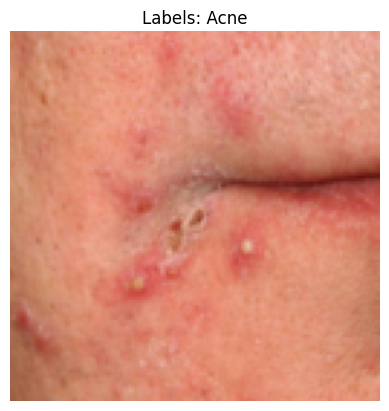

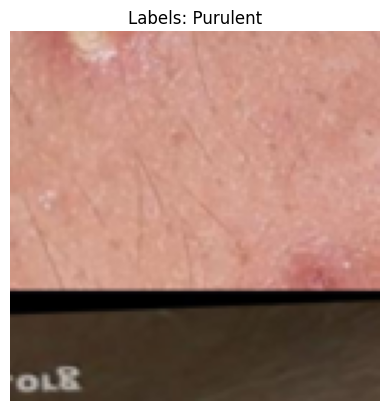

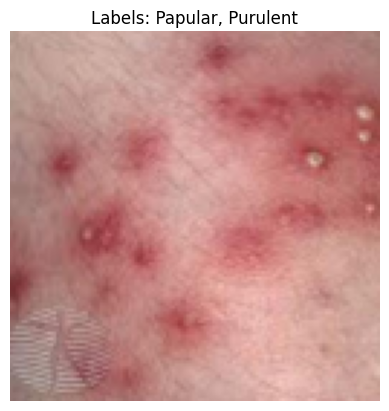

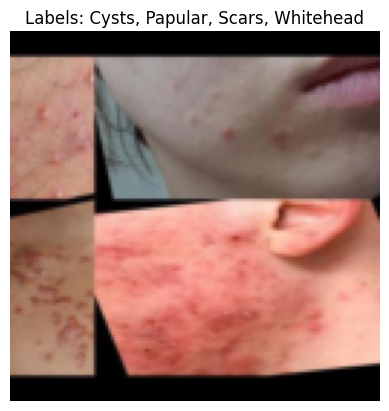

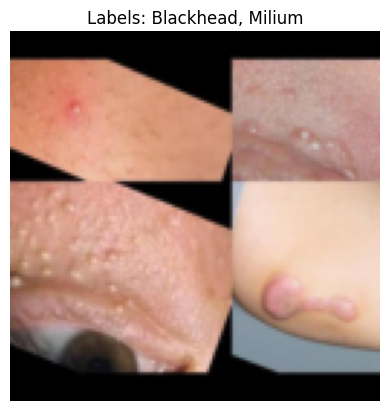

In [4]:
import matplotlib.pyplot as plt

# Hàm để hiển thị một ảnh cùng với nhãn
def show_image_with_label(image, label, classes):
    image = image.permute(1, 2, 0)  # Chuyển đổi tensor (C, H, W) thành (H, W, C)
    image = (image * 0.5) + 0.5  # Đưa ảnh về khoảng giá trị [0, 1] để hiển thị
    plt.imshow(image)
    # In nhãn của ảnh
    label_indices = torch.where(label == 1)[0]
    label_names = [classes[idx] for idx in label_indices]
    plt.title(f'Labels: {", ".join(label_names)}')
    plt.axis('off')
    plt.show()

# Tải lại các lớp nhãn từ label_encoder.json
with open('label_encoder.json', 'r') as f:
    label_encoder_data = json.load(f)
    classes = label_encoder_data['classes']

# Lấy vài mẫu từ DataLoader và hiển thị
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Hiển thị 5 hình ảnh đầu tiên cùng với nhãn tương ứng
for i in range(5):
    img = images[i]
    lbl = labels[i]
    show_image_with_label(img, lbl, classes)


In [5]:
import json

# Đường dẫn đến file
file_path = '/kaggle/working/label_encoder.json'

# Mở và đọc nội dung của file JSON
with open(file_path, 'r') as file:
    data = json.load(file)

# In ra nội dung của file
print(data)


{'classes': ['Acne', 'Birthmark', 'Blackhead', 'Cysts', 'Milium', 'Papular', 'Purulent', 'Scars', 'Whitehead']}


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Mô hình CNN đơn giản
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(train_dataset.label_encoder.classes_))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  

# Kiểm tra xem có GPU không, nếu có thì sử dụng
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)


In [7]:
print(f'Số lượng ảnh: {len(self.image_paths)}, Số lượng nhãn: {len(self.labels)}')


NameError: name 'self' is not defined

In [ ]:

# Định nghĩa criterion và optimizer
criterion = nn.BCEWithLogitsLoss()  # Sử dụng cho bài toán đa nhãn
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Huấn luyện mô hình
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')
    
    # Kiểm tra trên tập validation sau mỗi epoch
    model.eval()  # Chuyển sang chế độ kiểm tra
    val_loss = 0.0
    with torch.no_grad():  # Tắt việc tính gradient
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(valid_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

# Lưu mô hình nếu cần thiết
torch.save(model.state_dict(), 'model_multilabel.pth')


In [ ]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa dữ liệu kiểm tra
test_images_dir = '/kaggle/working/Acne-1/test'

# Lấy danh sách các tệp hình ảnh
test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

# Chọn một tấm ảnh bất kỳ
random_image_file = np.random.choice(test_images)
image_path = os.path.join(test_images_dir, random_image_file)

# Đọc và chuẩn hóa hình ảnh
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))  # Kích thước cần thiết
image = image / 255.0  # Chuẩn hóa
image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Thêm batch dimension

# Dự đoán với mô hình
model.eval()
with torch.no_grad():
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)

# Chuyển đổi ID lớp về tên lớp
predicted_label = train_dataset.label_encoder.inverse_transform(predicted.cpu().numpy())

# Hiển thị kết quả
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()


In [ ]:
import json
import torch
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa dữ liệu kiểm tra
test_images_dir = '/kaggle/working/Acne-1/test'

# Lấy danh sách các tệp hình ảnh
test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

# Chọn một tấm ảnh bất kỳ
random_image_file = np.random.choice(test_images)
image_path = os.path.join(test_images_dir, random_image_file)

# Đọc và chuẩn hóa hình ảnh
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))  # Kích thước cần thiết
image = image / 255.0  # Chuẩn hóa
image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Thêm batch dimension

# Dự đoán với mô hình
model.eval()
with torch.no_grad():
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    predicted = torch.sigmoid(output)  # Sử dụng sigmoid cho đầu ra
    predicted_labels = (predicted > 0.5).int()  # Chuyển sang nhãn nhị phân

# Chuyển đổi ID lớp về tên lớp
predicted_labels_indices = predicted_labels.cpu().numpy().flatten()
predicted_classes = train_dataset.label_encoder.inverse_transform(np.where(predicted_labels_indices == 1)[0])

# Đường dẫn đến file XML tương ứng
xml_path = os.path.join(test_images_dir, random_image_file.replace('.jpg', '.xml'))

# Lấy nhãn gốc
ground_truth = parse_xml(xml_path)

# Hiển thị kết quả
plt.imshow(image)
plt.title(f'Ground Truth: {ground_truth}\nPredicted Labels: {predicted_classes}')
plt.axis('off')
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()  # Áp dụng ngưỡng
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Chuyển đổi danh sách thành mảng NumPy
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(all_labels.flatten(), all_preds.flatten())
print("Confusion Matrix:")
print(cm)

# Hiển thị ma trận nhầm lẫn
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Hiển thị các giá trị trong ma trận
    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(cm, train_dataset.label_encoder.classes_)

# Tạo báo cáo phân loại
report = classification_report(all_labels, all_preds, target_names=train_dataset.label_encoder.classes_)
print(report)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
        
        all_preds.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches into a single array
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.label_encoder.classes_))



In [ ]:
# Generate the multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix for each class
for i, class_name in enumerate(train_dataset.label_encoder.classes_):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
# Print detailed classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.label_encoder.classes_)
print(report)


In [ ]:
for i, class_name in enumerate(train_dataset.label_encoder.classes_):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{class_name}.png')
    plt.close()  # Close the figure after saving


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all labels and predictions into a 1D array
flat_labels = all_labels.flatten()
flat_preds = all_preds.flatten()

# Generate the global confusion matrix
combined_conf_matrix = confusion_matrix(flat_labels, flat_preds)

# Plot the combined confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Global Confusion Matrix for All Labels')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have `all_labels` (ground truth) and `all_preds` (predictions) in binary format (shape: [n_samples, 9])
# Your class names for the 9 classes
class_names = ['Acne', 'Birthmark', 'Blackhead', 'Cysts', 'Milium', 'Papular', 'Purulent', 'Scars', 'Whitehead']

# Flatten the multilabels to treat each (true, predicted) pair as a single multiclass case
true_labels_flat = np.argmax(all_labels, axis=1)
pred_labels_flat = np.argmax(all_preds, axis=1)

# Generate the multiclass confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, pred_labels_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for All Classes (YOLO Style)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
